In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
class tcolors:
    GREEN = '\033[1;32;40m'
    ENDC = '\033[0m'

In [4]:
# 19 states (not including the ending state)
NUM_STATES = 1000 # 20 #1000
START = 500 # 10 # 500
END_0 = 0
END_1 = NUM_STATES + 1
STEP_RANGE = 100 # 5 # 100
NUM_BINS = 10 # 5 # 10


class RandomWalkEnv:

    def __init__(self, start=START, end=False, lr=0.1, gamma=1, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end


    def choose_action(self):
        action = np.random.choice(self.actions)
        return action

    def take_action(self, action):
        steps = np.random.choice(range(1, STEP_RANGE+1))
        
        if action == 'left':
            new_state = self.state - steps
        else:
            new_state = self.state + steps
            
        if new_state <= END_0:
            self.end = True
            self.state = END_0
        elif new_state >= END_1:
            self.end = True
            self.state = END_1
        else:
            self.end = False
            self.state = new_state
        return self.state

    def give_reward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        # other states
        return 0

    def reset(self):
        self.state = START
        self.end = False
        
        return self.state
        
    def step(self, action):
        return self.take_action(action), self.give_reward(), self.end, None
    
    def render(self):
        curr_state_str = ' '.join(map(str, list(range(END_0, self.state))))
        curr_state_str += f"{tcolors.GREEN} {self.state} {tcolors.ENDC}"
        curr_state_str += ' '.join(map(str, list(range(self.state+1, END_1+1))))
        print(curr_state_str)

In [5]:
env = RandomWalkEnv()

In [6]:
done = False
env.reset()
for i in itertools.count():
    action = env.choose_action()
    next_state, reward, done, info = env.step(action)
    if NUM_STATES < 30:
        env.render()
    if done:
        print(f'Steps : {i+1}')
        break

Steps : 113


### Part 1.1: Semi Gradient TD Control: Semi Gradient Sarsa N Step

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated action value corresponding to state `s` .

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [7]:
def get_epsilon_greedy_action(Q, state, eps):
    nA = len(Q[state])
    if np.random.random() > eps:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(nA)
    return action 

In [8]:
def plot_metrics(scores, steps):
    # sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    data = pd.DataFrame({'scores':scores, 'steps':steps})
    data = data.rolling(100).mean()
    data.index = pd.Series(range(len(scores)), name='episodes')
    
    sns.lineplot(data=data['scores'], color='green', ax=ax[0])
    sns.lineplot(data=data['steps'], color='orange', ax=ax[1])
    
    plt.show()

In [9]:
def plot_values(V):
    # bin state-value function
    # no of bins 10
    n_bin = 10
    bin_size = np.int(np.ceil(len(V) / n_bin))
    n_pad = (n_bin * bin_size) - len(V)
    
    binned_V = np.array(V, dtype=np.float)
    binned_V = np.pad(binned_V, (0, n_pad), 'constant', constant_values=np.NaN)
    binned_V = binned_V.reshape(n_bin, bin_size)

    avg_binned_V = np.nanmean(binned_V, axis=1, keepdims=True)
    avg_binned_V = avg_binned_V.reshape(1, -1)
    
    # plot the state-value function
    fig = plt.figure(figsize=(21,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(avg_binned_V, cmap='cool')
    for (j,i),label in np.ndenumerate(avg_binned_V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=9)
    plt.axis('off')
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('State-Value Function')
    plt.show()

In [10]:
def semi_sarsa_n(env, val_func_apprx, num_episodes, n, alpha, gamma=1.0):
    
    nA = len(env.actions)
     
    # Initialize epsilon
    eps_i = 1
    
    # Initialize performance metrics
    ep_scores = []
    ep_steps = []
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # metric
        score, step = 0, 0
        
        # state_0
        state = env.reset()

        # action_0
        # eps_i = 1/i_episode
        action = env.choose_action()
        
        # storage for state_t+1, reward_t+1. action_t+1
        state_list, reward_list, action_list = [state], [action], [0]

        # T 
        T = np.inf

        # t <- 0
        for t in itertools.count():
            # when t < T:
            if t < T:
                # Take action_t 
                next_state, reward, done, info = env.step(action)

                # store state_t+1 reward_t+1
                state_list.append(next_state)
                reward_list.append(reward)
                
                # update performance metric
                score += reward
                step += 1

                # if done :: set T <- t+1 
                if done:
                    T = t+1

                # else :: take next action
                else:
                    next_action = env.choose_action()
                    action_list.append(next_action)

            # calc update time -> tau
            tau = t - n + 1

            # if tau updatable ::
            if tau >= 0:

                # Calc G 
                G = 0
                start = tau + 1
                end = min(tau+n, T)
                
                for i in range(start, end+1):
                    G += math.pow(gamma, i-tau-1)*reward_list[i]

                # when tau+n < T, update G
                if tau + n < T:
                    state_tau_n = state_list[tau + n]
                    G += math.pow(gamma, n) * val_func_apprx.value(state_tau_n)
                    
                # update Q
                state_tau = state_list[tau]
                delta = G - val_func_apprx.value(state_tau)
                val_func_apprx.update(delta, state_tau)

            # break when tau = T - 1
            if tau == T - 1:
                break
                
            # t <- t + 1
            state = next_state
            action = next_action
            
        ep_scores.append(score)
        ep_steps.append(step)
        
    # Visualize performance
    plot_metrics(ep_scores, ep_steps)
    
    return val_func_apprx

### Part 1.2:  Function Approximator 
We will here implement 3 type of function approximators :
1. State Aggregation 
2. Polynomial Approximation
3. Fourier Appproximation

In [11]:
# Functions to plot weights of Approximators
def plot_weights(w):
    w = np.array(w)
    # reshape the state-value function
    w = np.reshape(w, (1, -1))
    # plot the state-value function
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(w, cmap='cool')
    for (j,i),label in np.ndenumerate(w):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=9)
    plt.axis('off')
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('Weights of State Aggregation')
    plt.show()

#### Part 1.2.1 : State Aggregation

In [12]:
class StateAggApproximator(object):
    def __init__(self, num_bins=NUM_BINS, alpha=0.01):
        self.num_bins = num_bins 
        self.alpha = alpha
        self.bin_size = NUM_STATES // self.num_bins
        self.weights = np.zeros(self.num_bins, dtype='float')
    
    def value(self, state):
        if state == END_0:
            return -1
        elif state == END_1:
            return 1
        else:
            bin_ = (state - 1)//self.bin_size
            return self.weights[bin_]
    
    def update(self, delta, state):
        grad = 1
        bin_ = (state - 1)//self.bin_size
        self.weights[bin_] = self.weights[bin_] + self.alpha * delta * grad

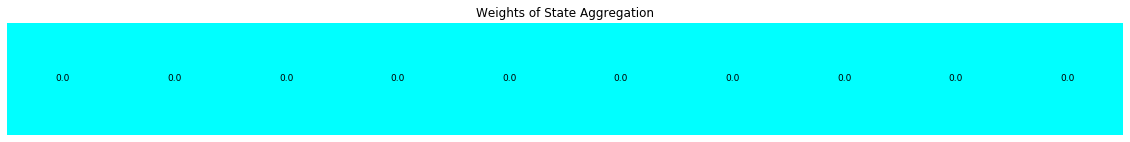

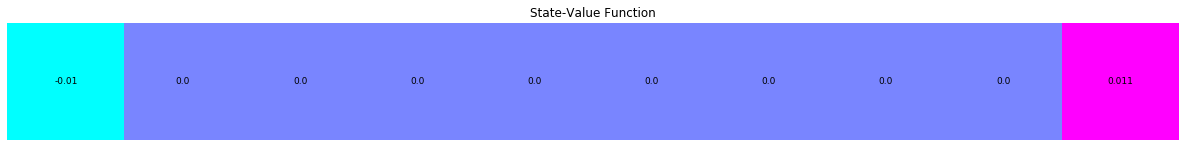

In [13]:
# Let's see an untrained State Aggregator
val_func_apprx = StateAggApproximator(alpha=0.01)
plot_weights(val_func_apprx.weights)

# Lets check state value for different states from a novice Aggregator
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

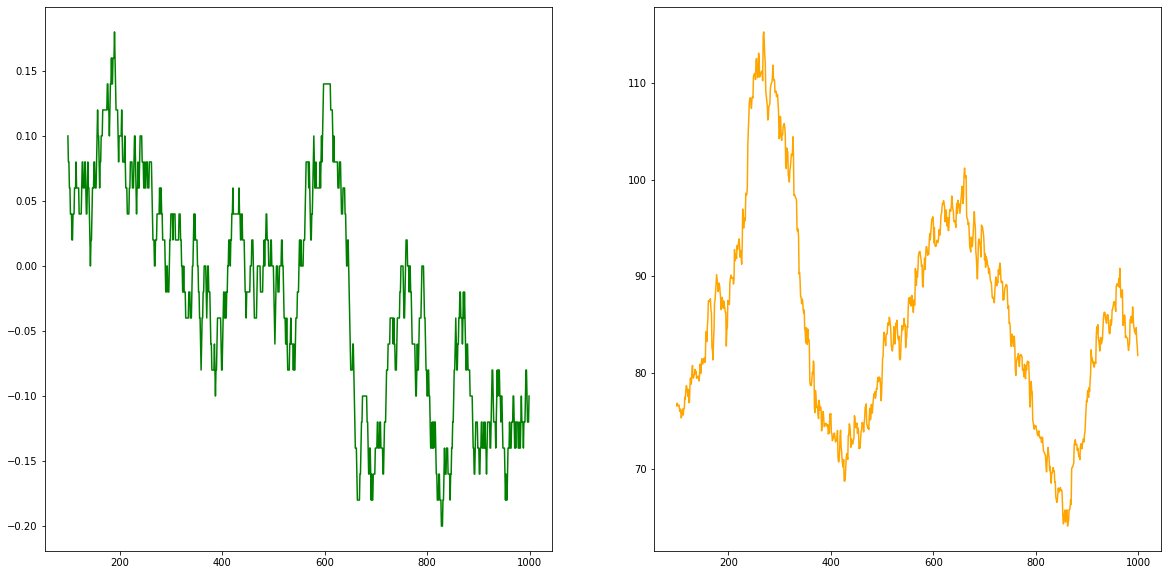

In [14]:
# Now Lets train Aggregator for 1000 episodes through interaction with Env
val_func_apprx = semi_sarsa_n(env, val_func_apprx, 1000, 5, 0.01)

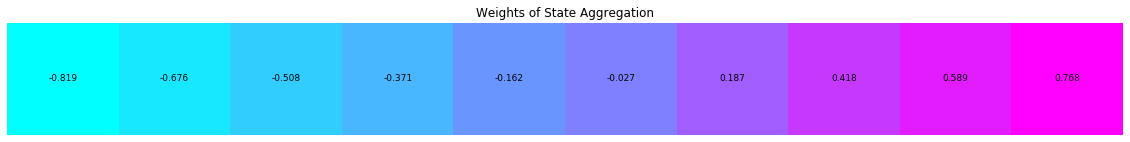

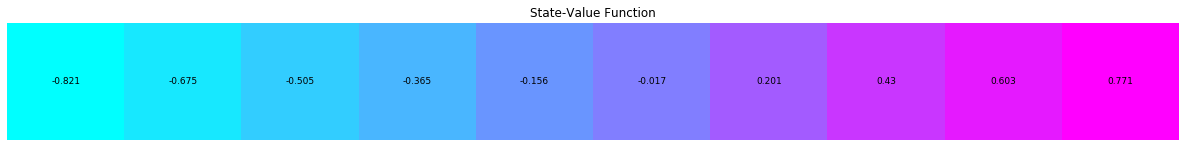

In [15]:
# Lets check weights again
# Aggregator has learned to represent state-value function more accurately
plot_weights(val_func_apprx.weights)

# Lets check state value for different states after training
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

#### Part 1.2.2 : Polynomial Approxiamtion

* Binned states
* Function Approximator on Binned States

In [13]:
class PolyApproximator(object):
    def __init__(self, num_bins=NUM_BINS, order=3, alpha=0.01):
        self.num_bins = num_bins 
        self.alpha = alpha
        self.bin_size = NUM_STATES // self.num_bins
        self.weights = np.zeros(order+1, dtype='float')
        self.func = [lambda x, i=i : np.power(x, i) for i in range(order+1)]
    
    def value(self, state):
        bin_ = (state - 1)//self.bin_size
        bin_ /= self.num_bins
        self.features = [f(bin_) for f in self.func]
        state_val = int(np.dot(self.weights, self.features))
    
        return state_val
    
    def update(self, delta, state):
        bin_ = (state - 1)//self.bin_size
        bin_ /= self.num_bins
        grad = np.array([f(bin_) for f in self.func])
        self.weights = self.weights + self.alpha * delta * grad

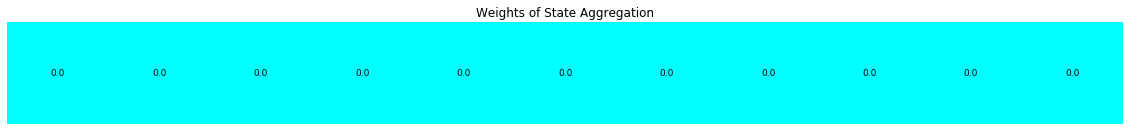

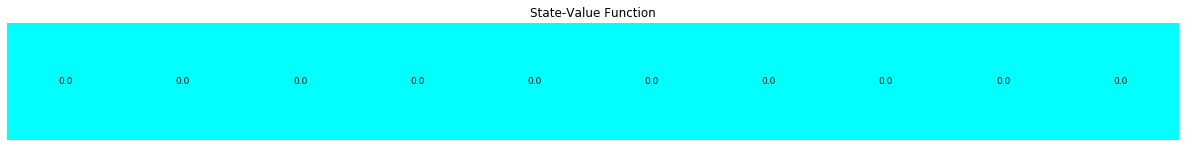

In [26]:
# Let's see an untrained Polynomial Approximator
# Polynomial Approxiamtor will learn gradually by interacting with environment 
val_func_apprx = PolyApproximator(num_bins=100, order=10, alpha=0.01)
plot_weights(val_func_apprx.weights)

# Lets check state value for different states from a novice Aggregator
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

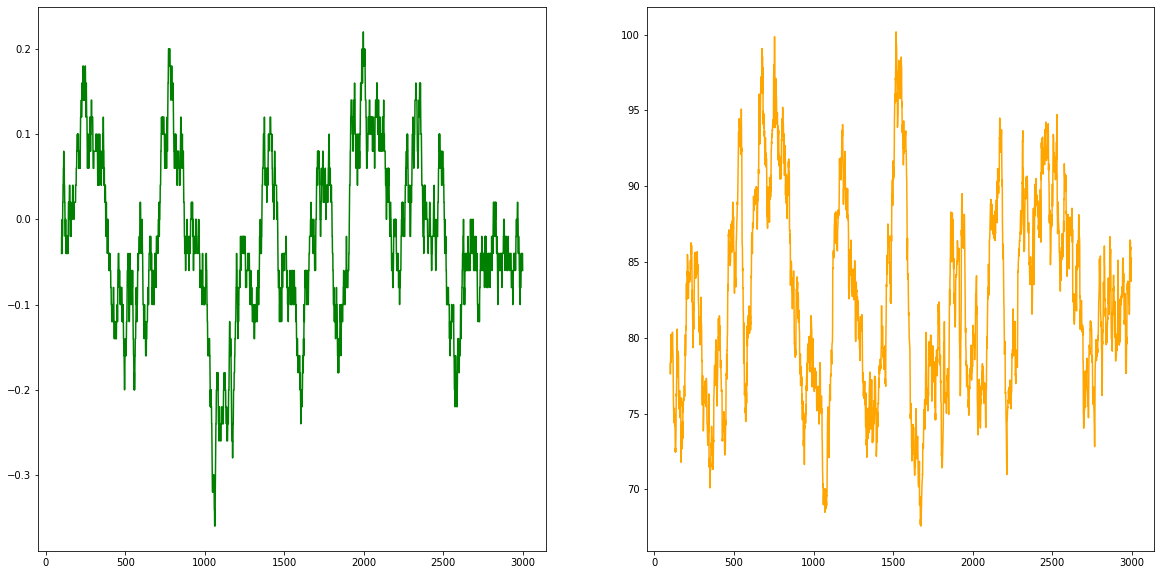

In [27]:
# Now Lets train Aggregator for 1000 episodes through interaction with Env
val_func_apprx = semi_sarsa_n(env, val_func_apprx, 3000, 5, 0.01)

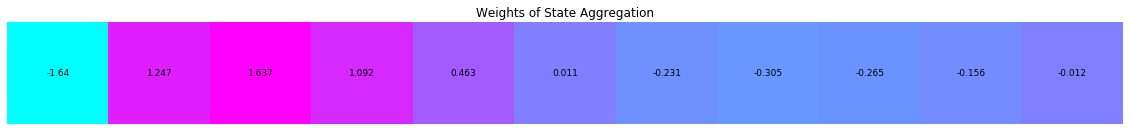

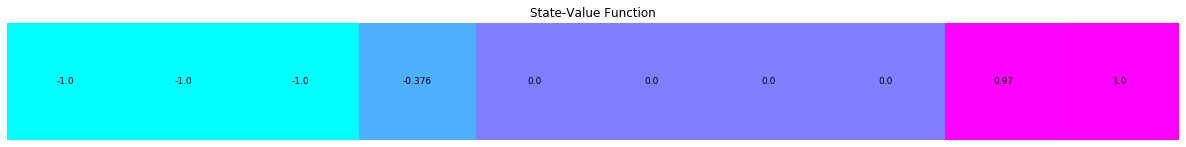

In [28]:
# Lets check weights again
# Aggregator has learned to represent state-value function more accurately
plot_weights(val_func_apprx.weights)

# Lets check state value for different states after training
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

#### Part 1.2.2 : Fourier Approxiamtion

* Actual states
* Function Approximator on actual States

In [14]:
class FourierApproximator(object):
    def __init__(self, num_bins=NUM_BINS, order=3, alpha=0.01):
        self.num_bins = num_bins 
        self.alpha = alpha
        self.bin_size = NUM_STATES // self.num_bins
        self.weights = np.zeros(order+1, dtype='float')
        self.func = [lambda x, i=i : np.cos(np.pi*x*i) for i in range(order+1)]
    
    def value(self, state):
        state_ = state / NUM_STATES
        self.features = [f(state_) for f in self.func]
        state_val = int(np.dot(self.weights, self.features))
    
        return state_val
    
    def update(self, delta, state):
        state_ = state / NUM_STATES
        grad = np.array([f(state_) for f in self.func])
        self.weights = self.weights + self.alpha * delta * grad

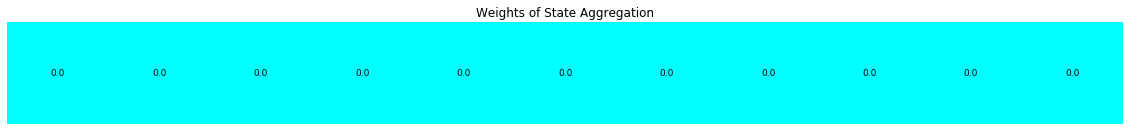

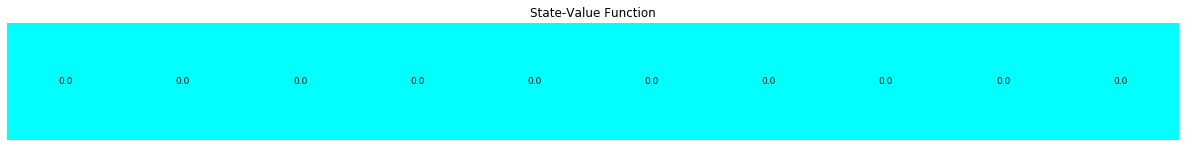

In [30]:
# Let's see an untrained Polynomial Approximator
# Polynomial Approxiamtor will learn gradually by interacting with environment 
val_func_apprx = FourierApproximator(num_bins=100, order=10, alpha=0.01)
plot_weights(val_func_apprx.weights)

# Lets check state value for different states from a novice Aggregator
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

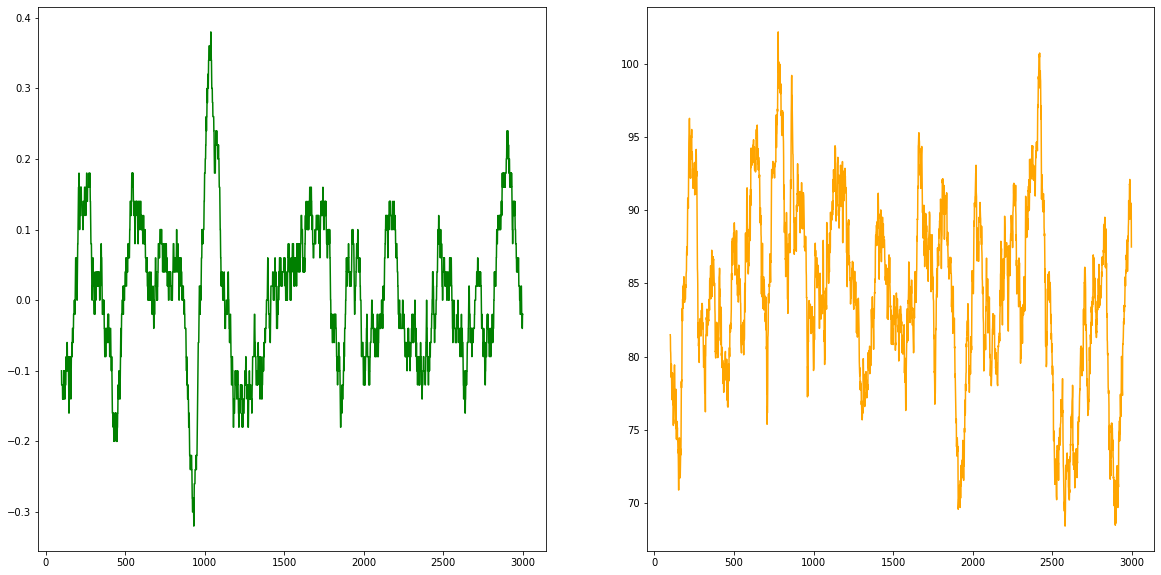

In [31]:
# Now Lets train Aggregator for 1000 episodes through interaction with Env
val_func_apprx = semi_sarsa_n(env, val_func_apprx, 3000, 5, 0.01)

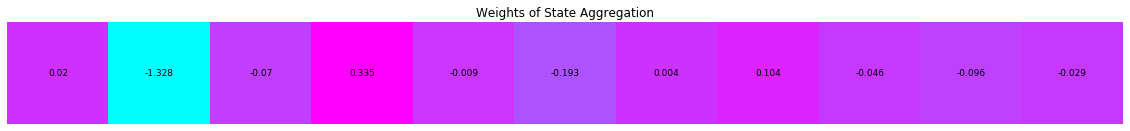

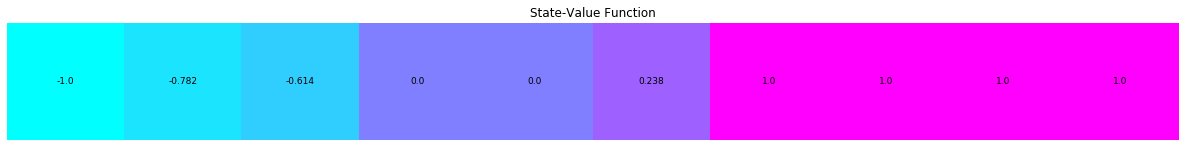

In [32]:
# Lets check weights again
# Aggregator has learned to represent state-value function more accurately
plot_weights(val_func_apprx.weights)

# Lets check state value for different states after training
V_semi_sarsa_n = ([val_func_apprx.value(state) for state in np.arange(END_1+1)])
plot_values(V_semi_sarsa_n)

## What's the True Value ?

In [15]:
def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    STATES = np.arange(1, NUM_STATES+1)
    ACTIONS = [-1, 1]
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action
                    next_state = state + step
                    next_state = max(min(next_state, NUM_STATES + 1), 0)
                    # asynchronous update for faster convergence
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value

In [16]:
V_true = compute_true_value()

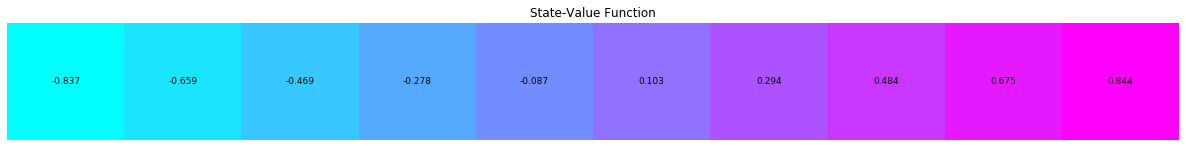

In [17]:
plot_values(V_true)

In [22]:
def plot_actual_vs_apprx_val(V_true, value_func_type):
    num_episodes = int(1e5)
    alpha = 2e-4
    n = 1
    STATES = np.arange(1, NUM_STATES+1)
    title_dict = {'Agg': 'State Aggregator',
             'Poly': 'Polynomial Approximator',
             'Fourier': 'Fourier Approximator'}
    
    if value_func_type == 'Agg':
        value_function = StateAggApproximator(alpha=alpha)
    elif value_func_type == 'Poly':
        value_function = PolyApproximator(alpha=alpha)
    elif value_func_type == 'Fourier':
        value_function = FourierApproximator(alpha=alpha)
    else:
        raise NotImplementedError
        
    env = RandomWalkEnv()    
    value_fucntion = semi_sarsa_n(env, value_function, num_episodes, n, alpha)


    V_semi_sarsa_n = [value_function.value(i) for i in STATES]
    plt.plot(STATES, V_semi_sarsa_n, label='Approximate TD value')
    plt.plot(STATES, V_true[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()
    plt.title(title_dict[value_func_type])
    plt.show()

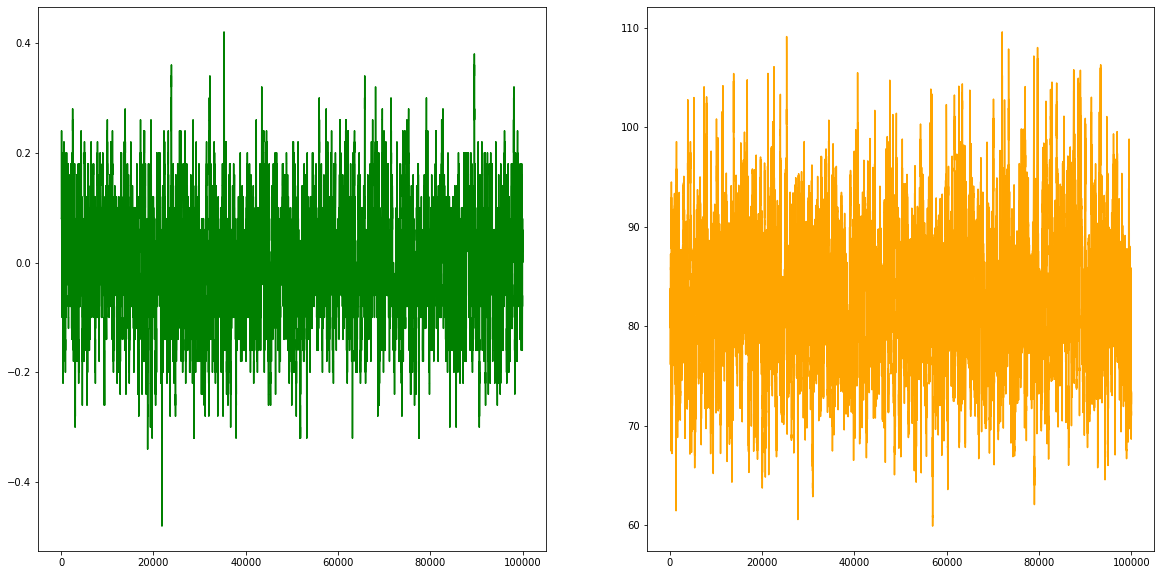

AttributeError: module 'matplotlib.pyplot' has no attribute 'totle'

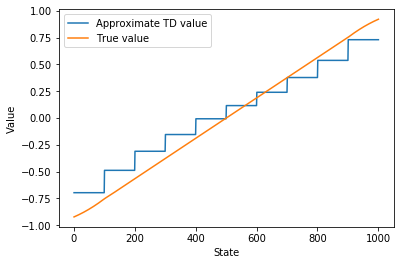

In [19]:
# State Aggregator
plot_actual_vs_apprx_val(V_true, 'Agg')

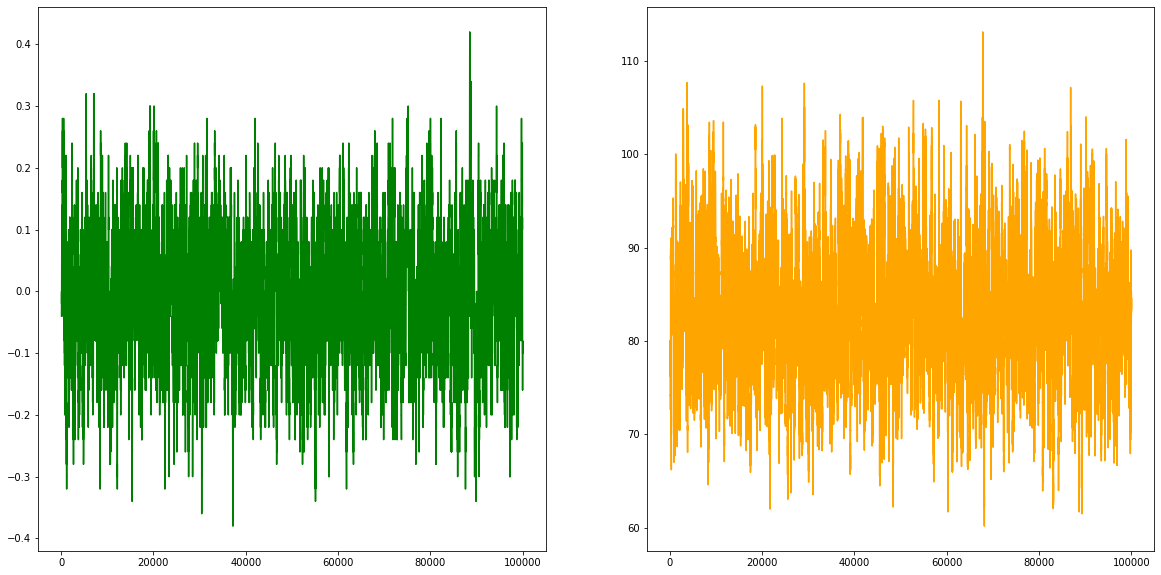

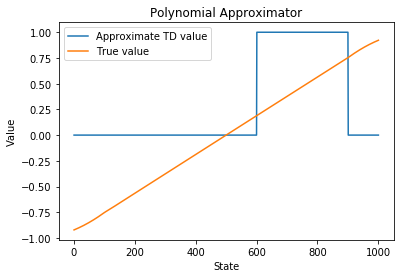

In [23]:
# Ploynomial Approxiamtor
plot_actual_vs_apprx_val(V_true, 'Poly')

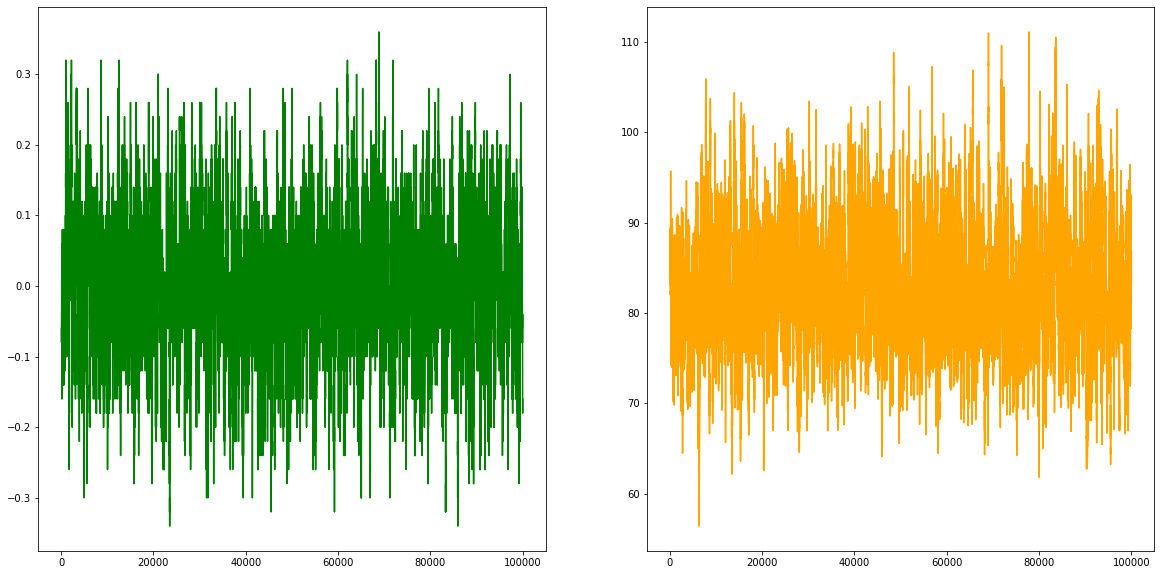

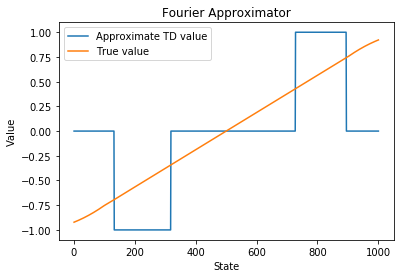

In [24]:
# Fourier Approxiamtor
plot_actual_vs_apprx_val(V_true, 'Fourier')